In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from sympy import diff,solve
import math
import matplotlib.patches as patches
import pylab

In [2]:
class three_phase:
    """
    Takes in three free energy functions and finds the correct phases at a given composition and temperature.
    The main functionality is to plot the free energy functions along with their common tangents in feasible areas
    and to return the overall phase diagram
    """
    def __init__(self,g_α,g_β,g_L,A=0):
        """
        We define the possible phases (7 total) for a three phase region. If they shall be named something else 
        for visual sake they can be renamed here e.g. fcc, bcc
        """
        self.g_α = g_α
        self.g_β = g_β
        self.g_L = g_L
        self.A = A
        self.phases = np.array(['αL','βL','αβ','αβL','α','β','L'])
    
    def alpha_L(self,g_α, g_L):
        """
        Input: Free energy functions for 'α' and 'Liquid' phases
        Return: The common tangent between the two phases (Linear)
        """
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        
        eq1 = (-diff(g_L) + diff(g_α))
        eq2 = (-diff(g_α) + (g_α - g_L)/(x_α - x_L))
        sol = solve((eq1,eq2),[x_α,x_L])
        if 0 <= sol[0][0] <= 1:
            x_α_,x_L_ = sol[0][0],sol[0][1]
        else:
            x_α_,x_L_ = sol[1][0],sol[1][1]
        x_α_,x_L_ = sol[0][0],sol[0][1]
        z_α_ = (X - x_L_)/(x_α_ - x_L_)
        z_L_ = 1 - z_α_
        return z_α_*g_α.subs(x_α, x_α_) + z_L_*g_L.subs(x_L, x_L_)
    
    def beta_L(self, g_β, g_L):
        """
        Input: Free energy functions for 'β' and 'Liquid' phases
        Return: The common tangent between the two phases (Linear)
        """
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        
        eq1 = (-diff(g_L) + diff(g_β))
        eq2 = (-diff(g_β) + (g_β - g_L)/(x_β - x_L))
        sol = solve((eq1,eq2),[x_β,x_L])

        if 0 <= sol[0][0] <= 1:
            x_β_,x_L_ = sol[0][0],sol[0][1]
        else:
            x_β_,x_L_ = sol[1][0],sol[1][1]
        z_β_ = (X - x_L_)/(x_β_ - x_L_)
        z_L_ = 1 - z_β_
        return z_β_*g_β.subs(x_β, x_β_) + z_L_*g_L.subs(x_L, x_L_)
    
    def alpha_beta(self,g_α, g_β):
        """
        Input: Free energy functions for 'α' and 'β' phases
        Return: The common tangent between the two phases (Linear if A = 0, otherwise non-linear)
        """
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        
        A = self.A
        
        eq1 = (-diff(g_α) + diff(g_β))
        eq2 = (-diff(g_β) + (g_β - g_α + A*(1-2*(x_α-X)/(x_α-x_β)))/(x_β - x_α))
        sol = solve((eq1,eq2),[x_α,x_β])

        x_α_,x_β_ = sol[0][0],sol[0][1]
        z_α_ = (X - x_β_)/(x_α_ - x_β_)
        z_β_ = 1 - z_α_
        return z_α_*g_α.subs(x_α,x_α_) + z_β_*g_β.subs(x_β,x_β_) + A*z_α_*z_β_ 
    
    def alpha_beta_L(self,g_α, g_β, g_L): 
        """
        Input: Free energy functions for 'α', 'β', and 'Liquid' phases
        Return: The common tangent between the three phases (Linear if A = 0, otherwise non-linear)
        """
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')

        A = self.A
        
        eq1 = (-diff(g_α) + diff(g_β))
        eq2 = (-diff(g_β) + diff(g_L))
        eq3 = (-diff(g_L) + (g_α - g_L + A*z_β)/(x_α - x_L))
        eq4 = (-diff(g_L) + (g_β - g_L + A*z_α)/(x_β - x_L))
        eq5 = (X - ((1-z_α-z_β)*x_L + z_α*x_α + z_β*x_β))
        sol = solve((eq1,eq2,eq3,eq4,eq5),[x_α,x_β,x_L,z_α,z_β])

        if np.size(sol) == 0:
            return float('inf')
        else:
            x_α_,x_β_,x_L_ = sol[0][0],sol[0][1],sol[0][2]
            z_α_,z_β_ = sol[0][3],sol[0][4]
            z_L_ = 1-z_α_-z_β_
        return z_α_*g_α.subs(x_α,x_α_) + z_β_*g_β.subs(x_β,x_β_) + z_L_*g_L.subs(x_L,x_L_) + A*z_α_*z_β_

    def inter_tan_G(self,com_tan,g_1,g_2,x_1,x_2):
        """
        Input: Two phase common tangent, associated free energy functions, variables to solve for
        Return: Boundaries of the feasible region
        """
        X = sy.symbols('X')
        
        eq1 = (com_tan - g_1.subs(x_1,X))
        sol_1 = solve((eq1),[X])
        eq2 = (com_tan - g_2.subs(x_2,X))
        sol_2 = solve((eq2),[X])
        return np.array([sy.re(sol_1[0]), sy.re(sol_2[0])])

    def correct_tangent(self,com_tan,intersection_G):
        """
        Input: Common tangent of two phase region, boundaries of the feasible region (from inter_tan_G)
        Return: Piecwise function which equals the common tangent in the feasible region 
                and infinity elsewhere
        """
        X = sy.symbols('X')
        
        new_tangent = sy.Piecewise(
            (float('inf'),X <= min(intersection_G) -1e-8), #account for some error
            (float('inf'),X >= max(intersection_G)+1e-8),
            (com_tan,True))
        return new_tangent
    
#Find the boundaries which the common tangents intersect
    def intersect_com_tans(self,com_tan_1,com_tan_2):
        """
        Input: Two common tangents of two phase regions
        Return: The intersection(s)
        """
        X = sy.symbols('X')

        eq1 = (com_tan_1 - com_tan_2)
        sol = np.array(solve((eq1),[X]))
        return sol[np.where((sol > 0)&(sol < 1))]

    def intersect_abl(self,com_abl,com_al,com_bl): 
        """
        Input: All three common tangents
        Return: The intersection(s)
        """
        X = sy.symbols('X')

        eq1 = (com_abl - com_al)
        sol_1 = solve((eq1),[X])
        if np.size(sol_1) == 0:
            sol_1 = [float('inf')]
        eq2 = (com_abl - com_bl)
        sol_2 = solve((eq2),[X])
        if np.size(sol_2) == 0:
            sol_2 = [float('inf')]
        return np.array([sy.re(sol_1[0]), sy.re(sol_2[0])])
    
    def correct_tangent_abl(self,com_tan,intersect_abl,al_G,bl_G):
        """
        Input: Common tangent of three phase region, boundaries of the feasible region (from intersect_abl),
                two phase common tangents
        Return: Piecwise function which equals the common tangent in the feasible region 
                and infinity elsewhere
        """
        X = sy.symbols('X')

        if min(al_G) <= intersect_abl[0] <= max(al_G):
            new_tangent = sy.Piecewise(
                (float('inf'),X <= min(intersect_abl) -1e-8), #account for some error
                (float('inf'),X >= max(intersect_abl)+1e-8),
                (com_tan,True))
        else:
            new_tangent = sy.Piecewise(
                (float('inf'),X <= 1 ), #account for some error
                (float('inf'),X >= 0))
        return new_tangent
    
    ##Find all of the points where a common tangent touches free energies and crosses other common tangents
    def important_points(self,g_α, g_β, g_L):
        """
        Input: Free energy functions of all phases
        Output:Three common tangents and an array of the intersection points between free energies and common tangents
        """
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        alpha_L,beta_L,alpha_beta,alpha_beta_L = self.alpha_L(g_α,g_L),self.beta_L(g_β,g_L),self.alpha_beta(g_α,g_β),self.alpha_beta_L(g_α,g_β,g_L)
        al_G = self.inter_tan_G(alpha_L,g_α,g_L,x_α,x_L)
        bl_G = self.inter_tan_G(beta_L,g_β,g_L,x_β,x_L)
        ab_G = self.inter_tan_G(alpha_beta,g_α,g_β,x_α,x_β)
        com_bl = self.correct_tangent(beta_L,bl_G)
        com_al = self.correct_tangent(alpha_L,al_G)
        com_ab = self.correct_tangent(alpha_beta,ab_G)
        al_bl = self.intersect_com_tans(com_al,com_bl)
        al_ab = self.intersect_com_tans(com_al,com_ab)
        ab_bl = self.intersect_com_tans(com_ab,com_bl)
        #Handle the three phase last
        #First finds the intersections
        abl_al_bl = self.intersect_abl(alpha_beta_L,alpha_L,beta_L)
        # computes the common tangent in feasible region 
        com_abl = self.correct_tangent_abl(alpha_beta_L,abl_al_bl,al_G,bl_G)
        # #add end points to full grid
        ends = np.array([0,1])
        grid_start = np.sort(np.concatenate((al_G,bl_G,ab_G,al_bl,al_ab,ab_bl,abl_al_bl)))
        grid_start = grid_start[np.where((0 < grid_start)&(1 > grid_start))]
        #create full grid to look (1e-# is to account for the minor errors and equal values at a point)
        grid_x = np.sort(np.concatenate((grid_start,grid_start*(1-1e-6),grid_start*(1+1e-6),ends)))
        self.grid_x = grid_x
        self.al_tangent = sy.lambdify(X,com_al)
        self.bl_tangent = sy.lambdify(X,com_bl)
        self.ab_tangent = sy.lambdify(X,com_ab)
        self.abl_tangent = sy.lambdify(X,com_abl) 
        
        return grid_x, self.al_tangent, self.bl_tangent, self.ab_tangent, self.abl_tangent
    
    def plot_specific_temp(self,Temp,x_lim = [0,0], y_lim = [0,0]):
        """
        Input: Array of temperatures, Optional: x_lim , y_lim
        Return: Snapshot of free energies and common tangents at specific temperature
        """
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        g_α, g_β, g_L = self.g_α.subs(T,Temp), self.g_β.subs(T,Temp), self.g_L.subs(T,Temp)
        self.important_points(g_α, g_β, g_L)
        x_grid = np.linspace(0,1,100)
        plt.plot(x_grid, sy.lambdify(x_α,g_α)(x_grid),color = 'blue',linestyle = 'dashed',label = 'α')
        plt.plot(x_grid, sy.lambdify(x_β,g_β)(x_grid),color = 'midnightblue',linestyle = 'dashed',label = 'β')
        plt.plot(x_grid, sy.lambdify(x_L,g_L)(x_grid),color = 'black', label = 'L')
        plt.plot(x_grid, self.al_tangent(x_grid),color = 'silver', label = 'αL')
        plt.plot(x_grid, self.ab_tangent(x_grid),color = 'blue', label = 'αβ')
        plt.plot(x_grid, self.bl_tangent(x_grid),color = 'dimgray', label = 'βL')
        plt.plot(x_grid, self.abl_tangent(x_grid), color = 'r',linewidth = 2,label = 'αβL')
        plt.title('Temp = ' + str(Temp) + ',A =' + str(self.A) )
        plt.xlabel('B Fraction')
        plt.ylabel('Gibbs Free energy')
        if x_lim[0] != x_lim[1]:
            plt.xlim(x_lim)
        if x_lim[0] != x_lim[1]:
            plt.ylim(y_lim)
        plt.legend()
        plt.show()

    def check_phase(self,g_α, g_β, g_L):
        """
        Input: All three free energy functions at a specific temperature
        Return: The phase boundaries at that temperature
        """
        X, x_α, x_β, x_L, z_α, z_β = sy.symbols('X, x_α, x_β, x_L, z_α, z_β')
        A = self.A
        exit = []
        self.important_points(g_α, g_β, g_L)
        G_L = sy.lambdify(x_L,g_L)
        G_a = sy.lambdify(x_α,g_α)
        G_b = sy.lambdify(x_β,g_β)
        
        for i,val in enumerate(self.grid_x):
            L = G_L(val)
            a = G_a(val)
            b = G_b(val)
            al = self.al_tangent(val)
            bl = self.bl_tangent(val)
            ab = self.ab_tangent(val)
            abl = self.abl_tangent(val)
            check = np.array([al,bl,ab,abl,a,b,L])
            index = np.argmin(check)
            exit.append(self.phases[index])
        exit = np.array(exit)

        exit = exit[self.grid_x>=0]    
        self.grid_x = self.grid_x[self.grid_x>=0] 

        res = {}
        for ph in self.phases: 
            idx = exit == ph
            if idx.any():
                res[ph] = {'c':[np.min(self.grid_x[idx]),np.max(self.grid_x[idx])]}
        
        return res
    
    def full_grid(self,Temp_grid):
        """
        Input: Array of temperatures
        Return: Array of all of the phase boundaries as the given temperatures
        """
        full_phases = []
        for t in Temp_grid:
            g_α = self.g_α.subs(T,t)
            g_β = self.g_β.subs(T,t)
            g_L = self.g_L.subs(T,t)
            full_phases.append(self.check_phase(g_α,g_β,g_L))
        return full_phases
        
    def organize_phases(self,Temp_grid):
        """
        Input: Array of Temperatures
        Return: Dictionary of the phase with an array of the phases at each temperature
        """
        grid = self.full_grid(Temp_grid)
        pd = {}
        patches = []
        for ph in self.phases: 
            pd[ph] = []
            for ii,res in enumerate(grid): 
                if ph in res.keys():
                    pd[ph].append([res[ph]['c'][0],Temp_grid[ii]])
                    pd[ph].append([res[ph]['c'][1],Temp_grid[ii]])
        return pd
    

    ##points in the form of the output from organize_phases
    def plot_diagram(self,Temp_grid,title = 'Phase plot',xlabel = 'B Fraction',ylabel = 'Temp'):
        """
        Input: Array of Temperatures
        Return: Phase diagram 
        """
        points = self.organize_phases(Temp_grid)
        for ph in self.phases: 
            pp = points[ph]
            if len(pp) > 0:
                cent=(sum([p[0] for p in pp])/len(pp),sum([p[1] for p in pp])/len(pp))
                # sort by polar angle
                pp.sort(key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
                # plot points
                pylab.scatter([p[0] for p in pp],[p[1] for p in pp],label = str(ph))
                # plot polyline
                pylab.gca().add_patch(patches.Polygon(pp,closed=True,fill=False)) 
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
#         plt.savefig(title)
        plt.show()

In [3]:
x_a, x_b, x_L,T = sy.symbols('x_α, x_β, x_L,T')
# phases = np.array(['αL','βL','αβ','αβL','α','β','L'])


x_a0,x_L0,x_b0 = .2,.5,.8
b_a,b_L,b_b = 10,12,11
a = 40

g_α = a*(x_a-x_a0)**2 + b_a
g_β = a*(x_b-x_b0)**2 + b_b
g_L = a*(x_L-x_L0)**2 + b_L - T

In [4]:
three_phase(g_α,g_β,g_L,1).__dict__

{'g_α': 40*(x_α - 0.2)**2 + 10,
 'g_β': 40*(x_β - 0.8)**2 + 11,
 'g_L': -T + 40*(x_L - 0.5)**2 + 12,
 'A': 1,
 'phases': array(['αL', 'βL', 'αβ', 'αβL', 'α', 'β', 'L'], dtype='<U3')}

In [5]:
hello = three_phase(g_α,g_β,g_L,A=1)

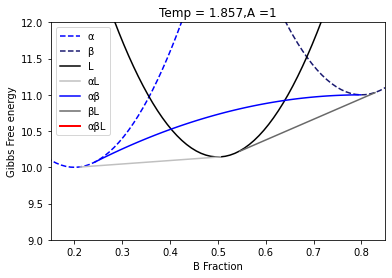

In [6]:
hello.plot_specific_temp(1.857,x_lim = [.15,.85],y_lim = [9,12])

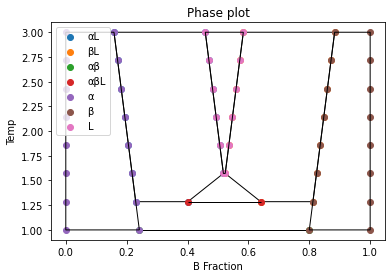

In [7]:
hello.plot_diagram(np.linspace(1,3,8))